In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

[*********************100%***********************]  1 of 1 completed
SPY mean  0.0005026767506150633
SPY std  0.012957250525543966


C:\Users\linru\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


{3: 0.08025247971145176, 0: 1.0, 1: 0.4409377817853922, 2: 0.1869552149083258, 4: 0.03396453261196273, 5: 0.013525698827772768, 6: 0.004809137360985873, 7: 0.0018034265103697023, 8: 0.00030057108506161706}
      index       Date       Close   returns  ConsD      Desp  Desp_roll  \
39       39 2008-07-28   94.861000 -0.014664      3  2.817701   0.829521   
40       40 2008-07-29   96.886475  0.021352      0 -0.000000   0.829521   
41       41 2008-07-30   98.612785  0.017818      0 -0.000000   0.829521   
42       42 2008-07-31   97.308472 -0.013227      1  0.945789   0.808490   
43       43 2008-08-01   96.794426 -0.005283      2  1.318350   0.874407   
...     ...        ...         ...       ...    ...       ...        ...   
3361   3361 2021-10-06  434.899994  0.004156      0 -0.000000   1.184485   
3362   3362 2021-10-07  438.660004  0.008646      0 -0.000000   1.093881   
3363   3363 2021-10-08  437.859985 -0.001824      1  0.187564   0.945185   
3364   3364 2021-10-11  434.690002

C:\Users\linru\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


0.429684438127075
0.572
Historical rolling Desperation high: 2.684409005696941


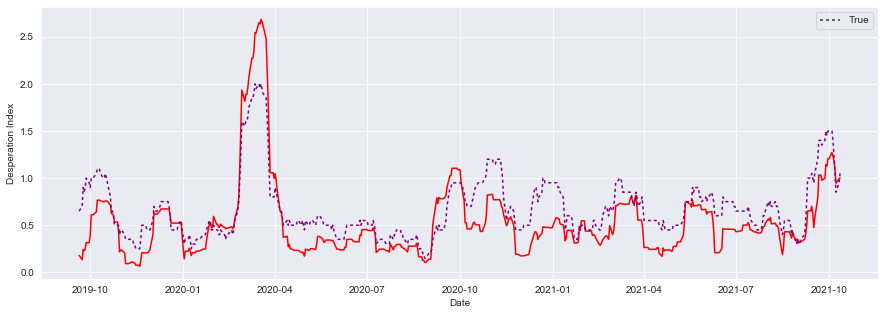

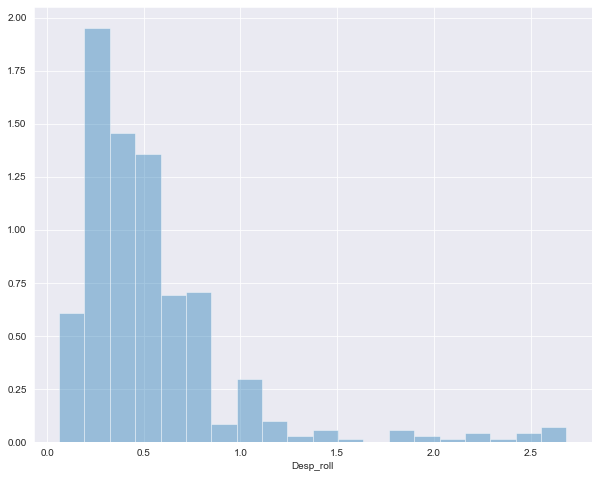

In [2]:
spy = yf.download('SPY','2008-6-1',date.today())
spy = spy.loc[:,['Adj Close']].rename(columns = {'Adj Close':'Close'})
spy.loc[:,'returns'] = spy.loc[:,'Close'].pct_change()
print('SPY mean ',spy.loc[:,'returns'].mean())
print('SPY std ',spy.loc[:,'returns'].std())

def findConsec(df):
    df.loc[:,'ConsD'] = [0]*len(df)
    ind = df.index
    df = df.reset_index()
    for i in range(1,len(df)):
        if df.loc[i,'returns'] < 0:
            df.loc[i,'ConsD'] = df.loc[i-1,'ConsD']+1
    df.set_index(ind)
    return df

def findDesp(df, window):
    df.loc[:,'Desp'] = [0.0]*len(df)
    ind = df.index
    df = df.reset_index()
    for i in range(1,len(df)):
        if df.loc[i,'returns'] < 0:
            df.loc[i,'Desp'] = df.loc[i-1,'Desp'] + df.loc[i,'returns']
            
    df.loc[:,'Desp'] = -df.loc[:,'Desp']/df.loc[:,'returns'].rolling(window).std()
    df.loc[:,'Desp_roll'] = df.loc[:,'Desp'].rolling(window).mean()
    df.set_index(ind)
    return df

window = 20
spy = findConsec(spy)
spy = findDesp(spy, window)

# compute discrete probability. 
def ConsDProb(df):
    df.loc[:,'PConsD'] = [0.0]*len(df)
    df = df.dropna(how = 'any')
    distDict = {}
    for val in df.loc[:,'ConsD'].unique():
        filt_greateq = df.loc[:,'ConsD'] >= val
        distDict[val] = len(df.loc[filt_greateq,:])/len(df)
    df.loc[:,'PConsD'] = df.loc[:,'ConsD'].apply(lambda x : distDict[x])
    print(distDict)
    return df
spy = ConsDProb(spy)
print(spy)

##### Graphing #####
plt.figure(figsize = [15,5])
sns.set_style('darkgrid')
# sns.lineplot(x = spy.index, y =spy.loc[:,'ConsD'])
# sns.lineplot(x = spy.index, y =spy.loc[:,'ConsD'].rolling(1).mean())
n = 500

sns.lineplot(x = spy.loc[len(spy)-n:,'Date'], y =spy.loc[len(spy)-n:,'Desp'].rolling(window).mean(),color = 'red')
sns.lineplot(x = spy.loc[len(spy)-n:,'Date'], y =spy.loc[len(spy)-n:,'ConsD'].rolling(window).mean(), color = 'purple', style=True, dashes=[(2,2)])
plt.xlabel('Date')
plt.ylabel('Desperation Index')
g2 = plt.figure(figsize = [10,8])
sns.distplot(spy.loc[len(spy)-n:,'Desp_roll'], kde = False, hist_kws = {'density':True, 'stacked': True}, bins = 20)

filt_temp = (spy.loc[len(spy)-n:,'Desp_roll'] > spy.loc[len(spy),'Desp_roll']).sum()/n
print(spy.loc[len(spy),'Desp_roll'])
print(filt_temp)
print('Historical rolling Desperation high:',spy.loc[len(spy)-n:,'Desp_roll'].max())

In [35]:
# for s in range(20,400,20):
#     min_return = spy.loc[len(spy)-s:,'returns'].min()
#     print('$SPY ',s,' trading days minimum return: ',round(min_return*100,2),'%',sep='')
#     print('    Minimum occurence on ',spy.loc[spy.loc[:,'returns'] == min_return,'Date'].values[0],sep='')

# spy.loc[spy.loc[:,'returns'] == min_return, 'Date']